In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as xforms

In [2]:
# Load the training and test datasets, build loaders to batch four images at a time, define
# a mapping from training image index to training image semantic label

# Normalize image as pix = ( pix - mean ) / std, moves pixel values from [0..1] to [-1..1]
# since we pass (0.5,0.5) as mean and standard deviation; to move back to the [0..1] range
# we can reverse this as pix = ( ( pix * 2 ) / mean ); the first argument is mean for R,G,B
# channels, the second argument is stdev for the three channels

xform = xforms.Compose( [ xforms.ToTensor(), xforms.Normalize( ( 0.5,0.5,0.5 ), (0.5,0.5,0.5) ) ] )

train_set = torchvision.datasets.CIFAR10( root='./data', train=True, download=True, transform=xform )
train_loader = torch.utils.data.DataLoader( train_set, batch_size=4, shuffle=True )

test_set = torchvision.datasets.CIFAR10( root='./data', train=False, download=True, transform=xform )
test_loader = torch.utils.data.DataLoader( test_set, batch_size=4, shuffle=False )

classes = ( 'plane','car','bird','cat','deer','dog','frog','horse','ship','truck' )

Files already downloaded and verified
Files already downloaded and verified


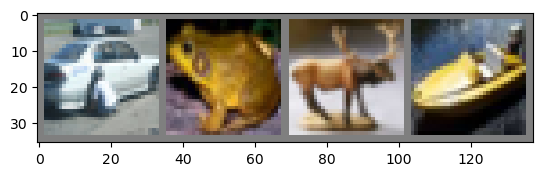

  car  frog  deer  ship


In [4]:
# Check a radom four images and their correct labels from the training set

def img_show( img ):
    
    #  Function to display a PyTorch normalized image
    
    img = img / 2 + 0.5  # Un-normalize
    np_img = img.numpy()  # Convert to numpy image format
    plt.imshow( np.transpose( np_img, ( 1, 2, 0 ) ) )
    plt.show()

# Retrieve random training images

data_iter = iter( train_loader )
images, labels = next(data_iter)

# Display images

img_show( torchvision.utils.make_grid( images ) )
print( ' '.join( '%5s' % classes[ labels[ j ] ] for j in range( 4 ) ) )

In [5]:
# Define the CNN: convolution, maxpool, convoloution, FCN 1/ReLU, FCN 2/ReLU, FCN 3

class Net( nn.Module ):
    def __init__( self ):
        super( Net, self ).__init__()
        
        self.conv_1 = nn.Conv2d( 3, 6, 5 )  # 2D convolution, in_channel=3 (RGB), out-channel=6, kernel-size=5x5
        self.pool = nn.MaxPool2d( 2, 2 )  # Pool by selecting max value, kernel-size=2, stride=2
        self.conv_2 = nn.Conv2d( 6, 16, 5 )  # 2D convolution, in_channel=6 (prev conv), out_channel=16, kernel-size=5x5
        self.fc_1 = nn.Linear( 16 * 5 * 5, 120 )  #  1D vectorize convolution results, feed into 120-node hidden layer
        self.fc_2 = nn.Linear( 120, 84 )  # Feed from first to second 84-node hidden layer
        self.fc_3 = nn.Linear( 84, 10 )  # Feed from second to 10-class output layer
        
    def forward( self, x ):
        x = self.pool( F.relu( self.conv_1( x ) ) )  # 1st convolve, ReLU, maxpool
        x = self.pool( F.relu( self.conv_2( x ) ) )  # 2nd convolve, ReLU, maxpool
        x = x.view( -1, 16 * 5 * 5 )  # Reshape tensor into req'd rows (-1) and 16*5*5 columns
        x = F.relu( self.fc_1( x ) )  # Pass through FCN 1st hidden layer, ReLU results
        x = F.relu( self.fc_2( x ) )  # Pass through FCN 2nd hidden layer, ReLU results
        x = self.fc_3( x )  # Provide class probabilities
        
        return x
    
net = Net()

In [6]:
# Set loss criteria and optimizer for backpropagation

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD( net.parameters(), lr=0.001, momentum=0.9 )  # Stochastic gradient descent

In [7]:
# Train the CNN on the training dataset for two epochs

for epoch in range( 2 ):
    step_loss = 0.0
    
    for i,data in enumerate( train_loader, 0 ):
        inputs,labels = data
        
        optimizer.zero_grad()  # Zero any previous gradient descent results
        
        outputs = net( inputs )  # Forward pass
        loss = criterion( outputs, labels )  # Compute error
        loss.backward()  # Backpropegation
        optimizer.step()  # Update weights
        
        step_loss += loss.item()  # Update current step error
        if ( i + 1 ) % 2000 == 0:  # Print step error every 2000 batches
            print( '[%d,%5d] loss: %.3f' % ( epoch + 1, i+1, step_loss / 2000.0 ) )
            step_loss = 0.0
            
    print( '[%d,%5d] loss: %.3f' % ( epoch + 1, i+1, step_loss / 2000.0 ) )
    
print( 'Training complete...' )

[1, 2000] loss: 2.230
[1, 4000] loss: 1.900
[1, 6000] loss: 1.695
[1, 8000] loss: 1.575
[1,10000] loss: 1.519
[1,12000] loss: 1.458
[1,12500] loss: 0.358
[2, 2000] loss: 1.390
[2, 4000] loss: 1.352
[2, 6000] loss: 1.329
[2, 8000] loss: 1.293
[2,10000] loss: 1.281
[2,12000] loss: 1.279
[2,12500] loss: 0.316
Training complete...


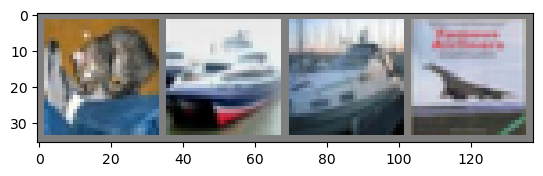

Ground Truth:    cat  ship  ship plane
Predicted:       dog  ship  ship plane


In [9]:
# Check accuracy for a random set of four images

data_iter = iter( test_loader )
images,labels = next( data_iter )

img_show( torchvision.utils.make_grid( images ) )
print( 'Ground Truth: ', ' '.join( '%5s' % classes[ labels[ j ] ] for j in range( 4 ) ) )

outputs = net( images )
_,predicted = torch.max( outputs, 1 )

print( 'Predicted:    ', ' '.join( '%5s' % classes[ predicted[ j ] ] for j in range( 4 ) ) )

In [10]:
# Check accuracy on test set

c = 0
n = 0

with torch.no_grad():
    for data in test_loader:
        images,labels = data
        outputs = net( images )
        _,predicted = torch.max( outputs.data, 1 )
        n += labels.size( 0 )
        c += ( predicted == labels ).sum().item()
        
print( 'Network accuracy on 10,000 test images: %d%%' % ( 100.0 * c / n ) )

Network accuracy on 10,000 test images: 55%


In [11]:
# Check accuracy for the 10 individual classes

class_c = list( 0.0 for i in range( 10 ) )
class_n = list( 0.0 for i in range( 10 ) )

with torch.no_grad():
    for data in test_loader:
        images,labels = data
        outputs = net( images )
        _,predicted = torch.max( outputs, 1 )
        
        c = ( predicted == labels ).squeeze()
        for i in range( 4 ):
            label = labels[ i ]
            class_c[ label ] += c[ i ].item()
            class_n[ label ] += 1
            
for i in range( 10 ):
    print( 'Accuracy for %5s: %2d%%' % ( classes[ i ], 100.0 * class_c[ i ] / class_n[ i ] ) )

Accuracy for plane: 45%
Accuracy for   car: 59%
Accuracy for  bird: 41%
Accuracy for   cat: 28%
Accuracy for  deer: 57%
Accuracy for   dog: 47%
Accuracy for  frog: 72%
Accuracy for horse: 61%
Accuracy for  ship: 80%
Accuracy for truck: 60%
